In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ResNet, ConvNext, ViT

import trainer as train_funct
from trainer import Trainer

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = SummaryWriter()

In [3]:
train_funct.set_seed(42)

## Dataset

In [4]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [5]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [6]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 32875
Validation: 4000
Test: 4000


In [8]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [9]:
print("Real: " + str(len(real_data.imgs)))

Real: 1500


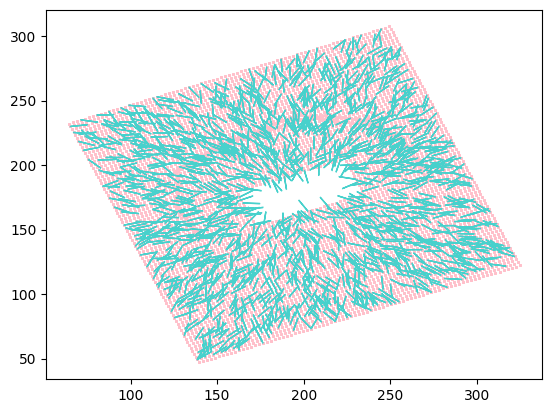

In [10]:
plotter.plot_train_data(train_data)

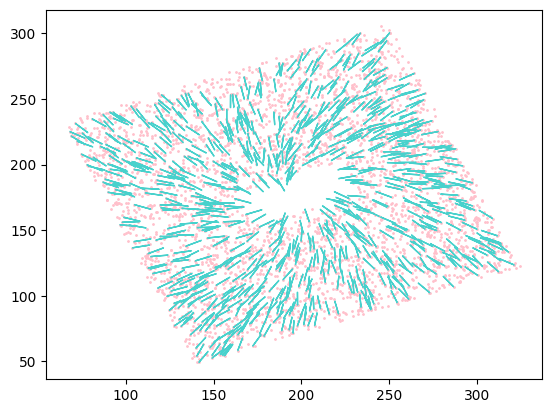

In [11]:
plotter.plot_data(val_data)

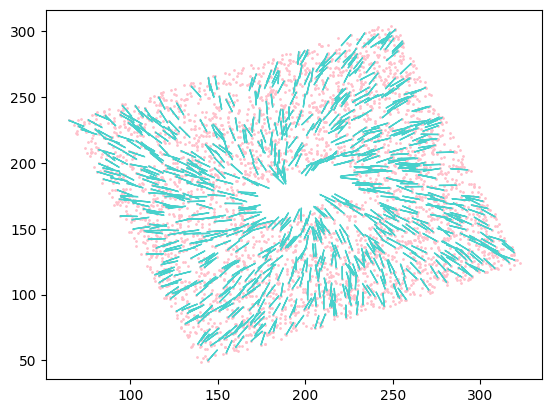

In [12]:
plotter.plot_data(test_data)

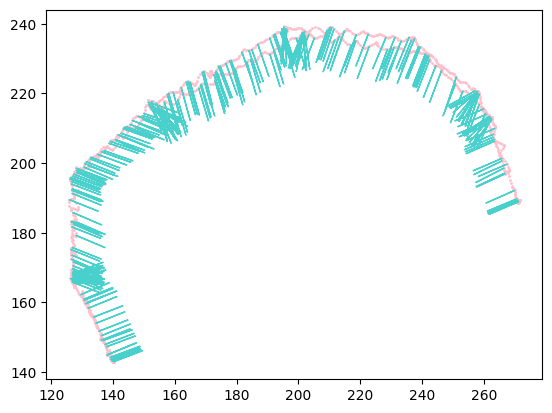

In [13]:
plotter.plot_data(real_data)

In [14]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Training before filtering: 32875


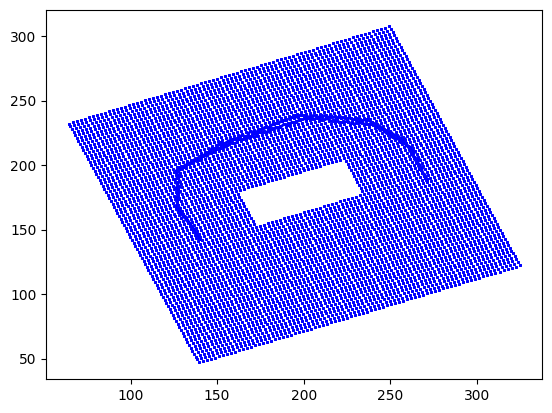

In [15]:
plotter.plot_synth_poses_train(train_data, "blue")
print("Training before filtering: " + str(len(train_data.imgs)))

Filtering poses: 100%|████████████████| 32875/32875 [00:00<00:00, 359607.09it/s]


Train after filtering: 28060


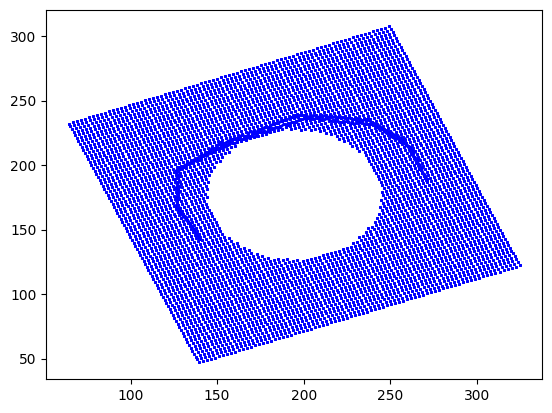

In [16]:
visualizer.filter_train_data(train_data)

plotter.plot_synth_poses_train(train_data, "blue")

print("Train after filtering: " + str(len(train_data.imgs)))

Validation before filtering: 4000


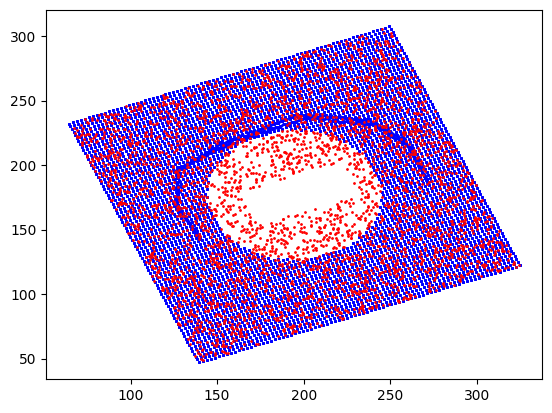

In [17]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1783.34it/s]


Validation after filtering: 3490


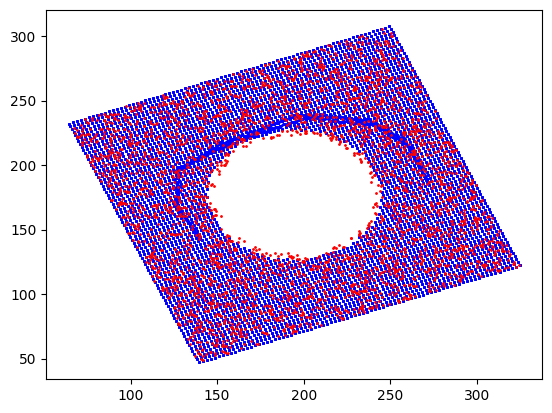

In [18]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


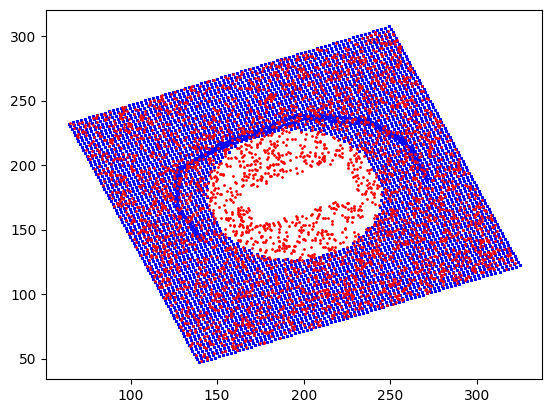

In [19]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1778.55it/s]


Test after filtering: 3502


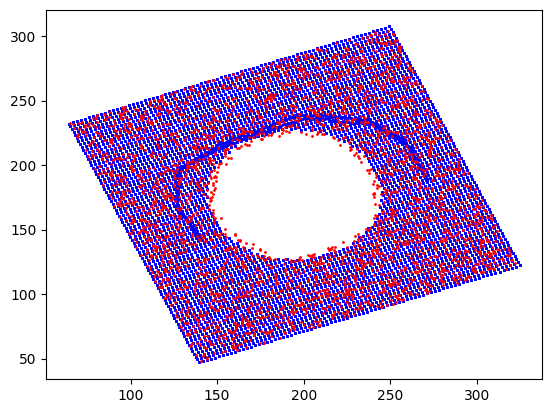

In [20]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

IndexError: index 1500 is out of bounds for dimension 0 with size 1500

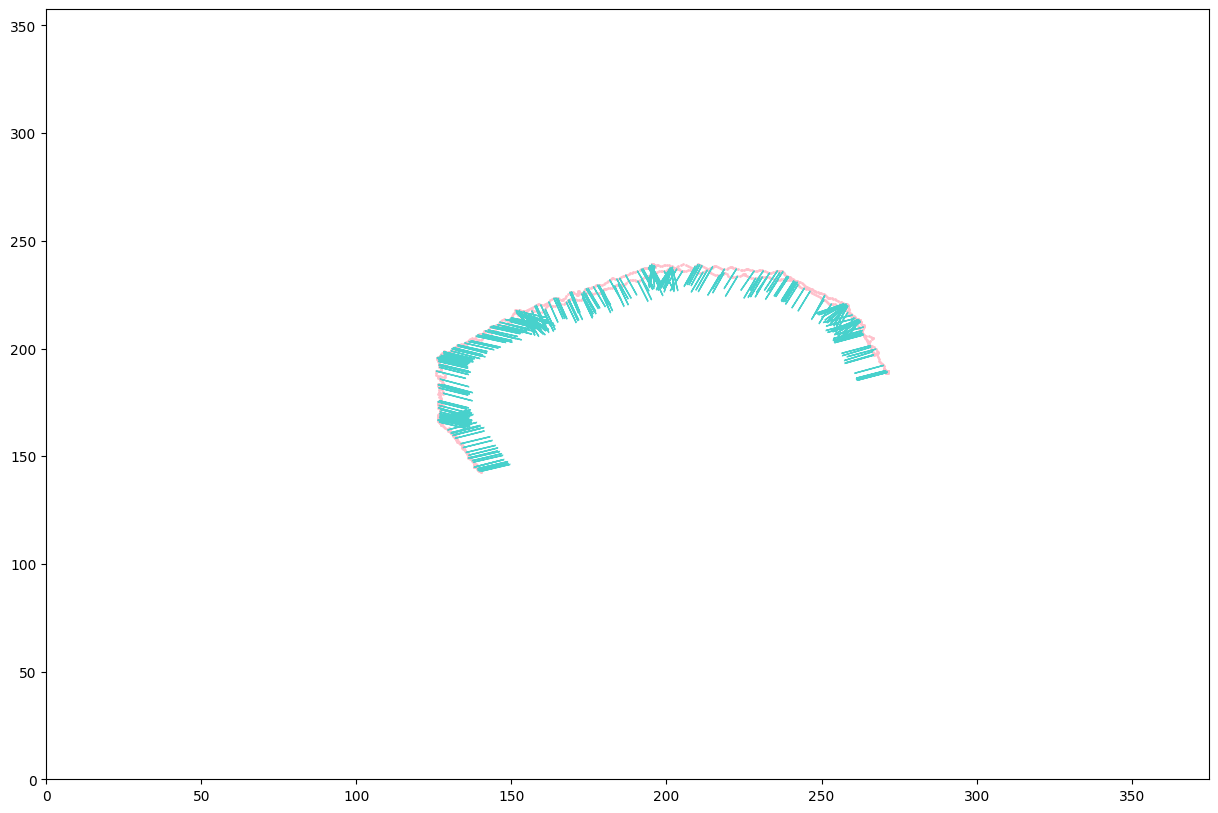

In [21]:
visualizer.localization(train_data, val_data, real_data)

In [22]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 28060
Validation: 3490
Test: 3502


In [23]:
val_data = visualizer.check_gt(train_data, val_data)

In [24]:
test_data = visualizer.check_gt(train_data, test_data)

In [25]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 28060
Validation: 3437
Test: 3455


In [26]:
model_name = "PVT_r"

In [27]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [133]:
net = PVT.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [29]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [89]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  74288645


## Training Pipeline

### Train epochs

In [30]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|█████████████████████████████████████| 2005/2005 [1:13:31<00:00,  2.20s/it]


train loss mean: 0.13322934076059934
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:51<00:00, 252.73it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:20<00:00, 166.71it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:27<00:00,  7.67it/s]


average localization error: 2.8203 meters
average orientation error : 24.4041 degrees
epoch: 2


100%|█████████████████████████████████████| 2005/2005 [1:13:18<00:00,  2.19s/it]


train loss mean: 0.02880627392440514
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:56<00:00, 240.12it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:15<00:00, 226.58it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:49<00:00,  7.32it/s]


average localization error: 2.6989 meters
average orientation error : 23.7353 degrees
epoch: 3


100%|█████████████████████████████████████| 2005/2005 [1:14:09<00:00,  2.22s/it]


train loss mean: 0.028401087783741535
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [02:26<00:00, 191.86it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:18<00:00, 187.43it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:36<00:00,  7.53it/s]


average localization error: 3.0533 meters
average orientation error : 27.0738 degrees
epoch: 4


100%|█████████████████████████████████████| 2005/2005 [1:13:58<00:00,  2.21s/it]


train loss mean: 0.023471992395056453
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:51<00:00, 251.63it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:13<00:00, 254.21it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:30<00:00,  7.62it/s]


average localization error: 3.4622 meters
average orientation error : 30.0262 degrees
epoch: 5


100%|█████████████████████████████████████| 2005/2005 [1:13:24<00:00,  2.20s/it]


train loss mean: 0.022048277098063073
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:46<00:00, 264.32it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:13<00:00, 260.90it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:32<00:00,  7.60it/s]


average localization error: 4.6022 meters
average orientation error : 39.8597 degrees
epoch: 6


100%|█████████████████████████████████████| 2005/2005 [1:13:01<00:00,  2.19s/it]


train loss mean: 0.01506625972548848
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:49<00:00, 256.81it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:13<00:00, 251.16it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:27<00:00,  7.68it/s]


average localization error: 5.6135 meters
average orientation error : 48.3810 degrees
epoch: 7


100%|█████████████████████████████████████| 2005/2005 [1:13:00<00:00,  2.18s/it]


train loss mean: 0.02386450733399562
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:45<00:00, 267.19it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:13<00:00, 258.99it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:23<00:00,  7.74it/s]


average localization error: 9.7834 meters
average orientation error : 81.4708 degrees
epoch: 8


100%|█████████████████████████████████████| 2005/2005 [1:12:59<00:00,  2.18s/it]


train loss mean: 0.018590696081937176
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:48<00:00, 257.65it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:20<00:00, 171.79it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:22<00:00,  7.76it/s]


average localization error: 9.3676 meters
average orientation error : 77.6863 degrees
epoch: 9


100%|█████████████████████████████████████| 2005/2005 [1:12:50<00:00,  2.18s/it]


train loss mean: 0.02040474144648993
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:45<00:00, 266.74it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:13<00:00, 262.10it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:27<00:00,  7.69it/s]


average localization error: 9.0560 meters
average orientation error : 74.7008 degrees
epoch: 10


 38%|███████████████                         | 757/2005 [27:30<45:20,  2.18s/it]


KeyboardInterrupt: 

In [134]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

111it [00:04, 22.79it/s]

Inference time per image:  0.025510011934766583 seconds


In [32]:
input_tensor = next(iter(train_dataloader))[0].cuda()
inference_memory_per_batch = metrics.inference_memory(net, input_tensor)
print("Inference memory for batch: ", inference_memory_per_batch, "MB")

Inference memory for batch:  1290.73193359375 MB


In [33]:
metrics.get_descriptors(train_data, val_data, net)

100%|████████████████████████████████████| 28060/28060 [04:07<00:00, 113.25it/s]


computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [04:10<00:00, 111.91it/s]
/home/firp/Desktop/Notebook_bsd/metrics.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_pred_embeds = torch.Tensor(train_data.descriptors)


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:30<00:00, 111.86it/s]


descriptors computed!
torch.Size([3437]) torch.Size([3437, 5])
avg_metric_e     : tensor(100.8282)
avg_metric_e_top5: tensor(45.6094)


## Visualize Training results on Test data

### Load the checkpoint model

In [94]:
#checkpoint_path = best_model_path
#print("Best model path: ", best_model_path)
checkpoint_path = "Best_checkpoints/PVT_r.pth"
net = PVT.Model()
train_funct.load_state(net, checkpoint_path)

net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [48]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████| 28060/28060 [05:12<00:00, 89.68it/s]

descriptors computed!


### Visualize query results: sonar images

In [49]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-1.3301, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.4630, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-1.9227, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.7616, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-2.8379, device='cuda:0', grad_fn=<MinBackward1>) tensor(5.2832, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-5.2004, device='cuda:0', grad_fn=<MinBackward1>) tensor(7.4391, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.8709, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6236, device='cuda:0', grad_fn=<MaxBackward1>)


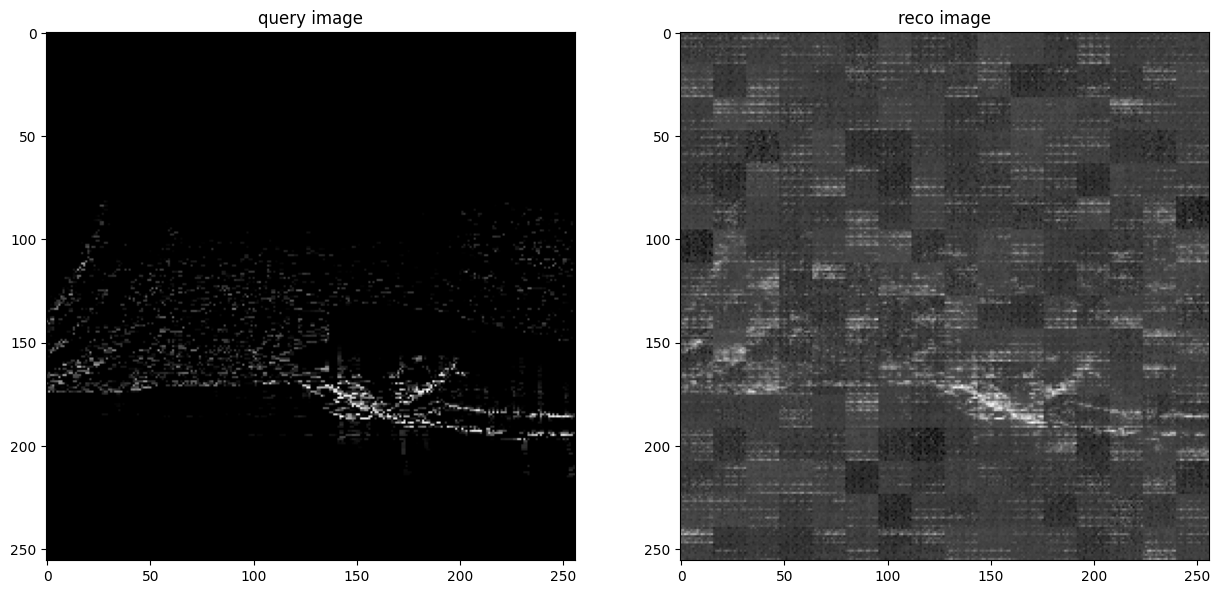

In [50]:
visualizer.analyze_feature_robustness(train_data, net)

In [95]:
num_runs = 100
total_time = 0.0

for _ in range(num_runs):
    query_idx = random.randint(0, len(test_data))
    
    start_time = time.time()
    loca_error, orie_error = visualizer.process_time(query_idx, net, train_data, test_data, plot=False)
    end_time = time.time()

    elapsed_ms = (end_time - start_time) * 1000
    total_time += elapsed_ms

average_time = total_time / num_runs

print(f"Average inference time over {num_runs} runs: {average_time:.2f} ms")

Average inference time over 100 runs: 139.44 ms


In [71]:
query_idx = random.randint(0, len(test_data))
start_time = time.time()
loca_error, orie_error = visualizer.process_time(query_idx, net, train_data, test_data, plot=False)
end_time = time.time()
elapsed_ms = (end_time - start_time) * 1000
print("time: ", elapsed_ms)

time:  145.72930335998535


iou: 0.9282611736699745
localization error: 0.5000 meters
orientation error : 3.0327 degrees


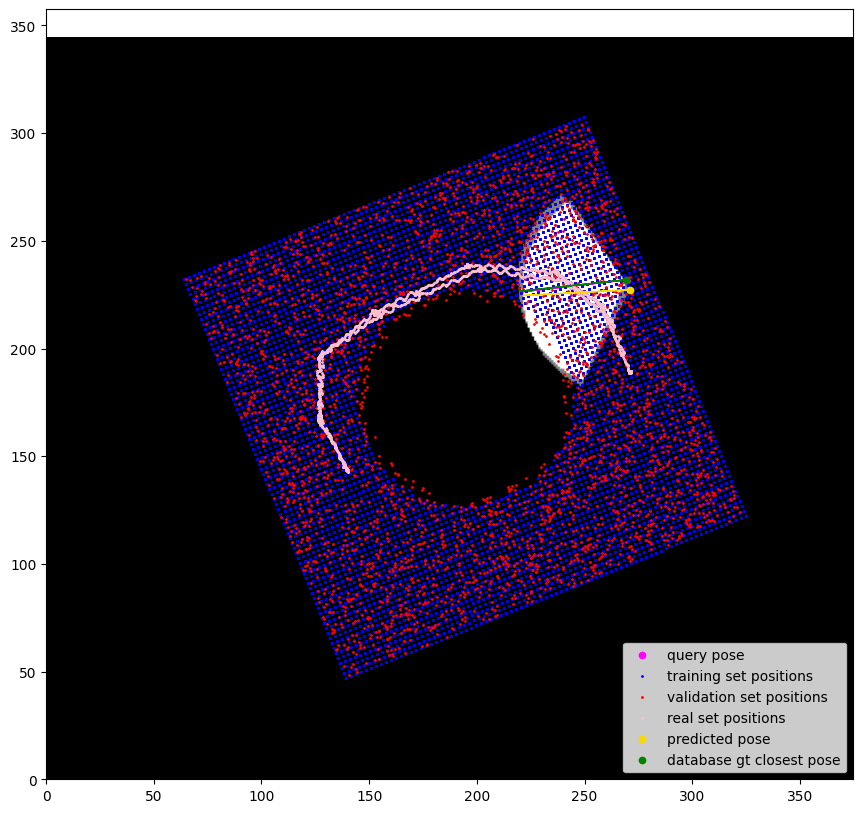

<Figure size 640x480 with 0 Axes>

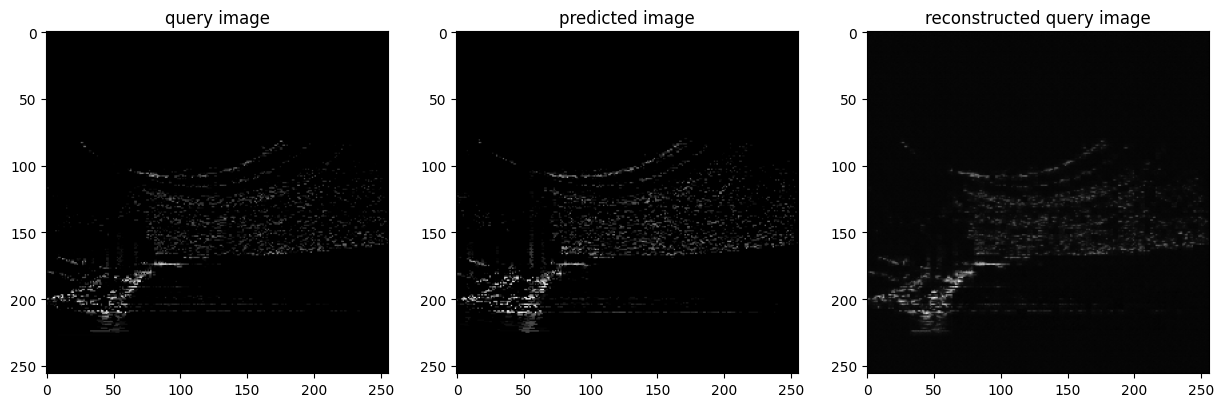

In [53]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

In [ ]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [ ]:
loca_errors.argmax()

In [ ]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

## Process real images

In [ ]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [ ]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [45]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|████████████████████████████████████████| 710/710 [00:03<00:00, 225.79it/s]

descriptors computed!


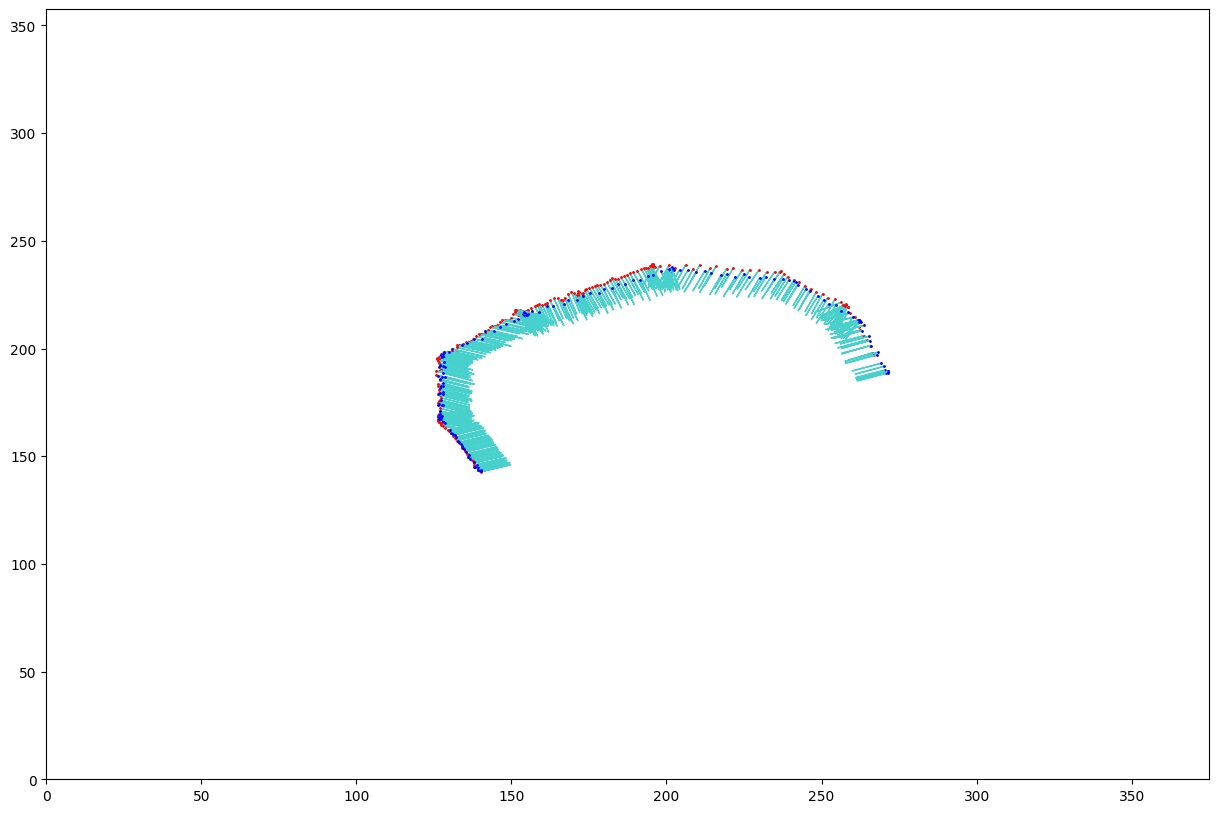

In [46]:
visualizer.visualize_real(train_data, real_data)

731
iou: 0.834564795248717
localization error: 0.2300 meters
orientation error : 1.9767 degrees


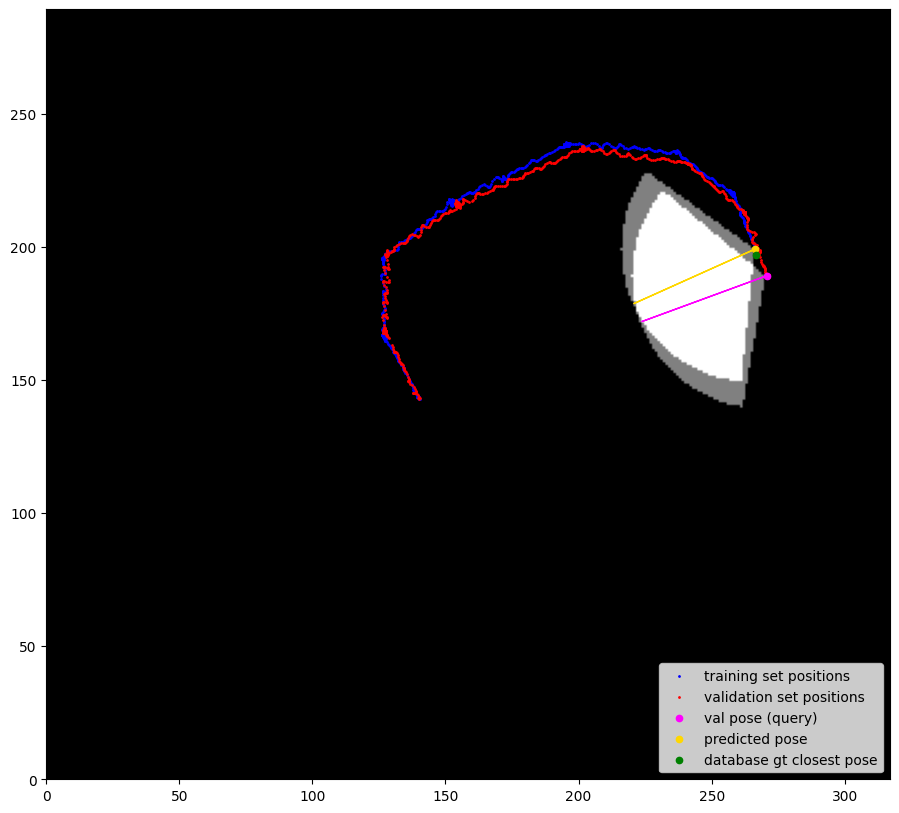

<Figure size 640x480 with 0 Axes>

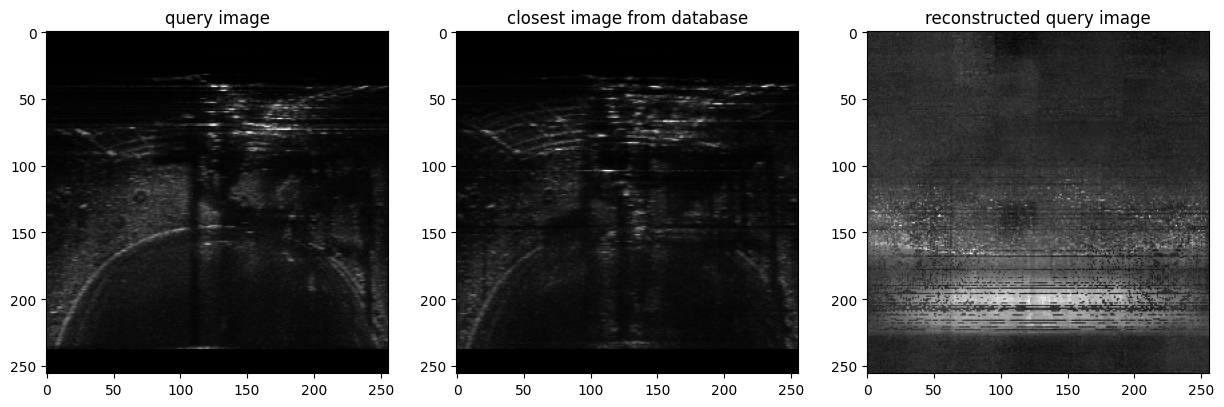

In [47]:
query_idx = random.randint(700, len(real_data_valid))
print(query_idx)
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [48]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

100%|█████████████████████████████████████████| 785/785 [00:13<00:00, 58.32it/s]

average localization error: 1.1784 meters
average orientation error : 13.4652 degrees


In [49]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [50]:
avg_orie_error.min()

np.float32(13.465213)

In [51]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

0.94653034
1.7667814


## Results

In [ ]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, inference_memory_per_batch, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Inference memory per batch: {inference_memory_per_batch:6.4f} MB")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")